# Phase 4. Extensions

## Pipeline requested for the extension

**Object detection**

- leveraging already existing and trained YOLO model we'll be able to find BBox for RGB images

**ROI**

- for each BBox crop RGB image accordingly
- crop the same exact point on corresponding depth file

**Feat extraction**

Feature extraction happens leveraging two different CNNs:
- *RGB Branch*: feature extraction from RGB cropped image
- *Depth Branch*: feature extraction from depth cropped image. Depth is threated as a 2D image, not a cloud of dots.

**Fusion**

$f_{\text{fused}}=concat(f_{\text{rgb}},f_{\text{depth}})$

**Pose estimation**

Pose estimation is done by a regressor (MLP)

# Step 1: Object detection

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from config import Config
from models.yolo_detector import YOLODetector

print(f"✅ Imports completati")
print(f"   Device: {Config.DEVICE}")
print(f"   PyTorch: {torch.__version__}")

Cache Strategy: full
✅ Imports completati
   Device: cuda
   PyTorch: 2.7.1+cu118


In [2]:
# Load pre-trained YOLO model
yolo_ckpt = Config.CHECKPOINT_DIR / 'yolo' / 'yolo_train20' / 'weights' / 'best.pt'

if yolo_ckpt.exists():
    yolo_detector = YOLODetector(
        model_name=str(yolo_ckpt),
        num_classes=Config.NUM_CLASSES
    )
    print(f"✅ YOLO loaded from: {yolo_ckpt}")
else:
    raise FileNotFoundError(f"YOLO checkpoint not found: {yolo_ckpt}")

✅ Loading custom weights from: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\yolo\yolo_train20\weights\best.pt
✅ YOLO loaded from: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\yolo\yolo_train20\weights\best.pt


In [3]:
# Test YOLO detection on a sample image
from dataset.linemod_pose import LineMODPoseDataset

# Load test dataset to get sample images
test_dataset = LineMODPoseDataset(
    dataset_root=Config.LINEMOD_ROOT,
    split='test',
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE
)

# Get a sample
sample = test_dataset[0]
rgb_path = sample['rgb_path']
depth_path = sample['depth_path']
gt_bbox = sample['bbox'].numpy()  # Ground truth bbox [x, y, w, h]

print(f"📷 Sample image: {rgb_path}")
print(f"📏 GT BBox [x,y,w,h]: {gt_bbox}")

📷 Sample image: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\data\Linemod_preprocessed\data\01\rgb\0004.png
📏 GT BBox [x,y,w,h]: [        246         191          43          56]


In [4]:
# Run YOLO detection
image_bgr = cv2.imread(rgb_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

detections = yolo_detector.detect_objects(image_bgr, conf_threshold=0.3)

print(f"🎯 Detected {len(detections)} object(s)")
for i, det in enumerate(detections):
    print(f"   [{i+1}] Class: {det['class_name']}, Conf: {det['confidence']:.2f}, BBox: {det['bbox']}")

🎯 Detected 1 object(s)
   [1] Class: ape, Conf: 0.93, BBox: [     245.76      190.09      288.26      247.09]


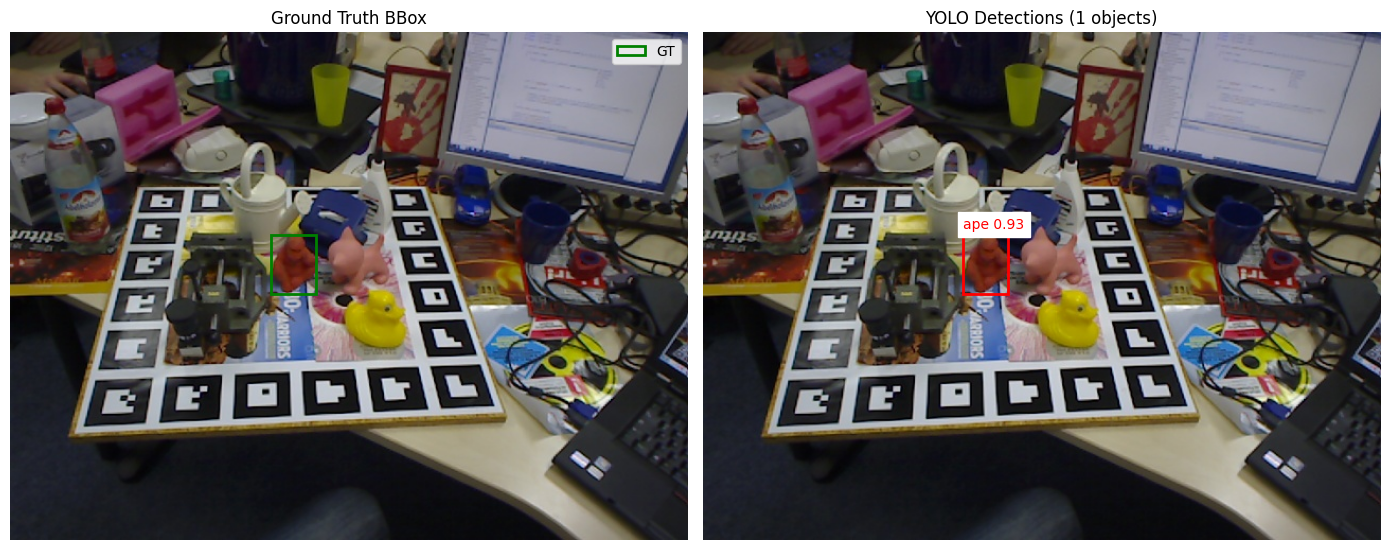


✅ Step 1 completed: Object detection with pre-trained YOLO


In [5]:
# Visualize detection results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original image with GT bbox
axes[0].imshow(image_rgb)
x, y, w, h = gt_bbox
rect_gt = plt.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2, label='GT')
axes[0].add_patch(rect_gt)
axes[0].set_title('Ground Truth BBox')
axes[0].legend()
axes[0].axis('off')

# Image with YOLO detections
axes[1].imshow(image_rgb)
for det in detections:
    x1, y1, x2, y2 = det['bbox']
    rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
    axes[1].add_patch(rect)
    axes[1].text(x1, y1-5, f"{det['class_name']} {det['confidence']:.2f}", 
                 color='red', fontsize=10, backgroundcolor='white')
axes[1].set_title(f'YOLO Detections ({len(detections)} objects)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Step 1 completed: Object detection with pre-trained YOLO")

# Step 2: ROI - Crop RGB and Depth

For each detected bounding box:
1. Crop the RGB image with a margin
2. Crop the corresponding depth map at the **same exact coordinates**
3. Resize both to a fixed size (224x224) for the CNN

In [6]:
def crop_roi(image: np.ndarray, bbox_xyxy: np.ndarray, margin: float = 0.15, output_size: int = 224):
    """
    Crop a region of interest from an image given a bounding box.
    
    Args:
        image: Input image (H, W, C) for RGB or (H, W) for depth
        bbox_xyxy: Bounding box [x1, y1, x2, y2]
        margin: Margin to add around the bbox (as fraction of bbox size)
        output_size: Output size for the crop (square)
    
    Returns:
        Cropped and resized image
    """
    x1, y1, x2, y2 = bbox_xyxy
    w, h = x2 - x1, y2 - y1
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Add margin and make it square
    size = max(w, h) * (1 + margin)
    half = size / 2
    
    # Compute crop coordinates (clipped to image bounds)
    img_h, img_w = image.shape[:2]
    x1_crop = int(max(0, cx - half))
    y1_crop = int(max(0, cy - half))
    x2_crop = int(min(img_w, cx + half))
    y2_crop = int(min(img_h, cy + half))
    
    # Crop
    if image.ndim == 3:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop, :]
    else:
        crop = image[y1_crop:y2_crop, x1_crop:x2_crop]
    
    # Resize to output size
    interp = cv2.INTER_LINEAR if image.ndim == 3 else cv2.INTER_NEAREST
    crop_resized = cv2.resize(crop, (output_size, output_size), interpolation=interp)
    
    return crop_resized


# Test on the first detection
if len(detections) > 0:
    det = detections[0]
    bbox = det['bbox']
    
    print(f"🎯 Using detection: {det['class_name']} (conf: {det['confidence']:.2f})")
    print(f"   BBox [x1,y1,x2,y2]: {bbox}")
else:
    # Fallback to GT bbox if no detection
    x, y, w, h = gt_bbox
    bbox = np.array([x, y, x+w, y+h])
    print(f"⚠️ No YOLO detection, using GT bbox: {bbox}")

🎯 Using detection: ape (conf: 0.93)
   BBox [x1,y1,x2,y2]: [     245.76      190.09      288.26      247.09]


In [7]:
# Crop RGB image
rgb_crop = crop_roi(image_rgb, bbox, margin=0.15, output_size=224)

# Load and crop depth image
depth_raw = np.array(Image.open(depth_path))  # uint16, values in mm
depth_crop = crop_roi(depth_raw, bbox, margin=0.15, output_size=224)

# Normalize depth to [0, 1] for visualization and network input
DEPTH_MAX = 2000.0  # mm (typical max depth in LineMOD)
depth_crop_normalized = np.clip(depth_crop / DEPTH_MAX, 0, 1)

print(f"✅ ROI crops created:")
print(f"   RGB crop shape: {rgb_crop.shape}")
print(f"   Depth crop shape: {depth_crop.shape}")
print(f"   Depth range: [{depth_crop.min():.0f}, {depth_crop.max():.0f}] mm")

✅ ROI crops created:
   RGB crop shape: (224, 224, 3)
   Depth crop shape: (224, 224)
   Depth range: [992, 1173] mm


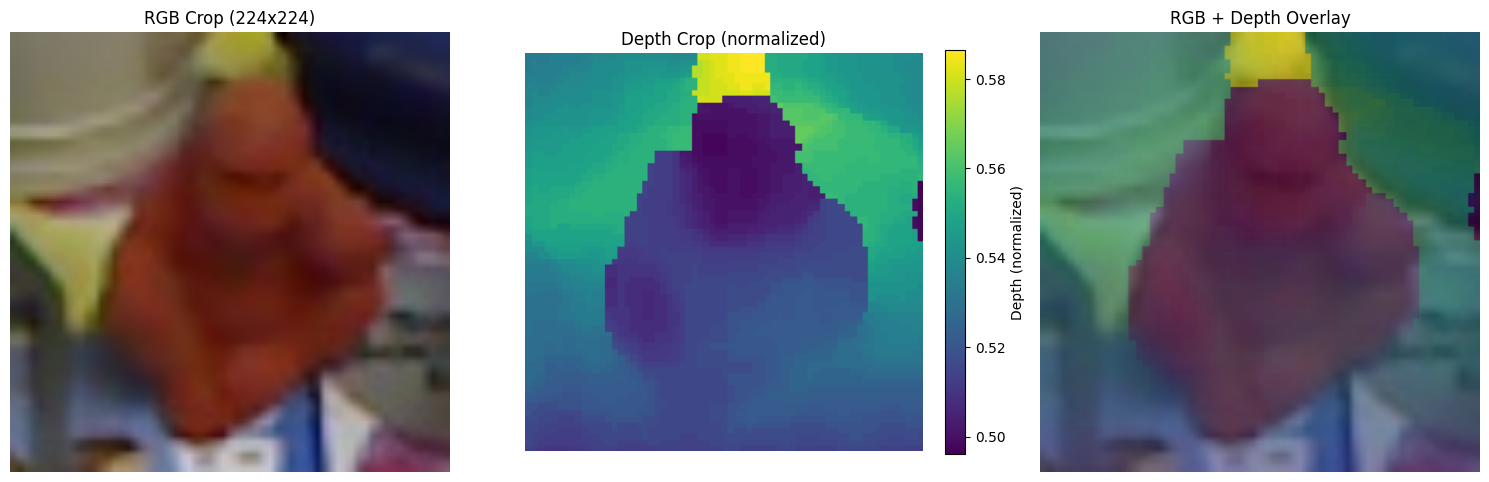


✅ Step 2 completed: ROI crops for RGB and Depth


In [8]:
# Visualize the crops
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RGB crop
axes[0].imshow(rgb_crop)
axes[0].set_title(f'RGB Crop ({rgb_crop.shape[0]}x{rgb_crop.shape[1]})')
axes[0].axis('off')

# Depth crop (normalized for visualization)
im = axes[1].imshow(depth_crop_normalized, cmap='viridis')
axes[1].set_title(f'Depth Crop (normalized)')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046, label='Depth (normalized)')

# RGB + Depth overlay
axes[2].imshow(rgb_crop)
axes[2].imshow(depth_crop_normalized, cmap='viridis', alpha=0.5)
axes[2].set_title('RGB + Depth Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Step 2 completed: ROI crops for RGB and Depth")

# Step 3: Feature Extraction

- **RGB Branch**: ResNet-18 backbone → 512-dim features
- **Depth Branch**: DepthEncoder CNN → 512-dim features (see `models/depth_encoder.py`)

In [9]:
# Feature extraction models
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
from models.depth_encoder import DepthEncoder

# RGB Branch: ResNet-18 (pretrained, without final FC)
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
rgb_encoder = nn.Sequential(*list(resnet.children())[:-1]).to(Config.DEVICE)
rgb_encoder.eval()

# Depth Branch: DepthEncoder
depth_encoder = DepthEncoder(output_dim=512).to(Config.DEVICE)
depth_encoder.eval()

print(f"✅ Feature extractors loaded:")
print(f"   RGB: ResNet-18 → 512-dim")
print(f"   Depth: DepthEncoder → 512-dim")

✅ Feature extractors loaded:
   RGB: ResNet-18 → 512-dim
   Depth: DepthEncoder → 512-dim


In [10]:
# Prepare tensors
from torchvision import transforms
import torch.nn as nn

# ImageNet normalization for RGB
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# RGB tensor
rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0
rgb_tensor = imagenet_normalize(rgb_tensor).unsqueeze(0).to(Config.DEVICE)

# Depth tensor
depth_tensor = torch.from_numpy(depth_crop_normalized).float().unsqueeze(0).unsqueeze(0).to(Config.DEVICE)

print(f"✅ Input tensors: RGB {rgb_tensor.shape}, Depth {depth_tensor.shape}")

✅ Input tensors: RGB torch.Size([1, 3, 224, 224]), Depth torch.Size([1, 1, 224, 224])


In [11]:
# Extract features
with torch.no_grad():
    f_rgb = rgb_encoder(rgb_tensor).squeeze()      # (512,)
    f_depth = depth_encoder(depth_tensor).squeeze() # (512,)

print(f"✅ Step 3 completed:")
print(f"   f_rgb: {f_rgb.shape}")
print(f"   f_depth: {f_depth.shape}")

✅ Step 3 completed:
   f_rgb: torch.Size([512])
   f_depth: torch.Size([512])


# Step 4: Fusion

Late fusion via concatenation:

$$f_{\text{fused}} = \text{concat}(f_{\text{rgb}}, f_{\text{depth}}) \in \mathbb{R}^{1024}$$

In [12]:
# Late fusion: concatenate RGB and Depth features
f_fused = torch.cat([f_rgb, f_depth], dim=0)

print(f"✅ Step 4 completed: Feature Fusion")
print(f"   f_rgb:   {f_rgb.shape[0]} dims")
print(f"   f_depth: {f_depth.shape[0]} dims")
print(f"   f_fused: {f_fused.shape[0]} dims (concatenated)")

✅ Step 4 completed: Feature Fusion
   f_rgb:   512 dims
   f_depth: 512 dims
   f_fused: 1024 dims (concatenated)


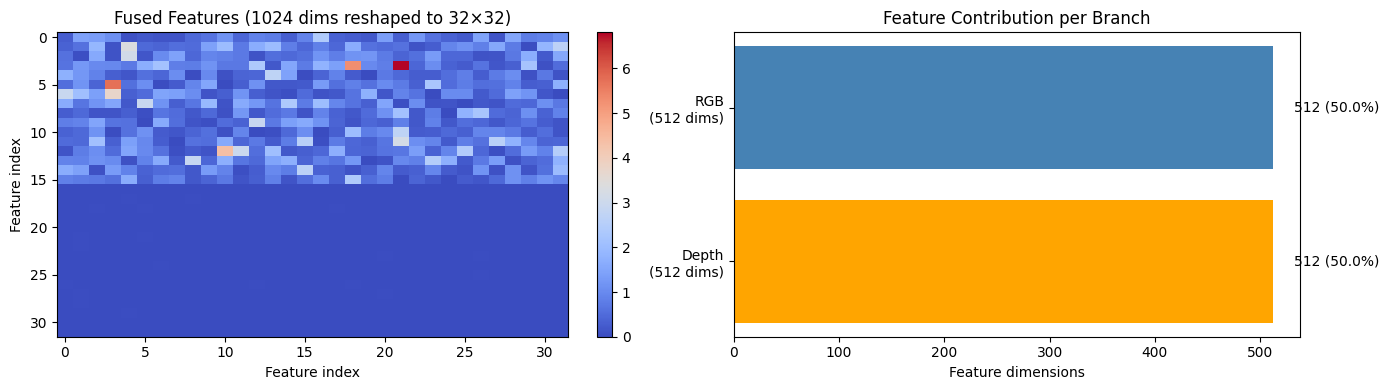

In [13]:
# Visualize fused feature vector
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Fused features as heatmap (reshaped for visualization)
f_np = f_fused.cpu().numpy()
# Reshape to 2D for better visualization (32x32 = 1024)
f_2d = f_np.reshape(32, 32)
im = axes[0].imshow(f_2d, cmap='coolwarm', aspect='auto')
axes[0].set_title(f'Fused Features (1024 dims reshaped to 32×32)')
axes[0].set_xlabel('Feature index')
axes[0].set_ylabel('Feature index')
plt.colorbar(im, ax=axes[0], fraction=0.046)

# Show contribution of each branch
axes[1].barh(['Depth\n(512 dims)', 'RGB\n(512 dims)'], [512, 512], color=['orange', 'steelblue'])
axes[1].set_xlabel('Feature dimensions')
axes[1].set_title('Feature Contribution per Branch')
for i, v in enumerate([512, 512]):
    axes[1].text(v + 20, i, f'{v} ({v/1024*100:.1f}%)', va='center')

plt.tight_layout()
plt.show()

# Step 5: Pose Estimation

MLP regressor predicts 6D pose from fused features:
- **Quaternion** (4D): $[q_w, q_x, q_y, q_z]$ normalized to unit norm
- **Translation** (3D): $[t_x, t_y, t_z]$ in meters

Input: 1024-dim fused features (512 RGB + 512 Depth)

See `models/pose_regressor.py`

In [14]:
# Pose regressor (for demo - without meta features)
from models.pose_regressor import PoseRegressor

# Note: This is just for pipeline demonstration
# During training, we'll use meta features → input_dim=1056
pose_regressor = PoseRegressor(input_dim=1024, dropout=0.3).to(Config.DEVICE)
pose_regressor.eval()

# Predict pose (model has random weights - just testing the pipeline)
with torch.no_grad():
    f_fused_batch = f_fused.unsqueeze(0)  # (1, 1024)
    pose_pred = pose_regressor(f_fused_batch).squeeze()  # (7,)

quat_pred = pose_pred[:4].cpu().numpy()
trans_pred = pose_pred[4:].cpu().numpy()

print(f"✅ Step 5 completed: Pose Estimation")
print(f"   Quaternion [qw,qx,qy,qz]: {quat_pred}")
print(f"   Quaternion norm: {np.linalg.norm(quat_pred):.6f}")
print(f"   Translation [tx,ty,tz]: {trans_pred}")


✅ Step 5 completed: Pose Estimation
   Quaternion [qw,qx,qy,qz]: [    0.40046     0.01169    -0.76754     0.50037]
   Quaternion norm: 1.000000
   Translation [tx,ty,tz]: [   -0.04056   -0.061344    0.027247]


In [15]:
# Compare with ground truth
gt_quat = sample['quaternion'].numpy()
gt_trans = sample['translation'].numpy()

print(f"📊 Comparison (random weights vs GT):")
print(f"   Predicted quat: {quat_pred}")
print(f"   GT quat:        {gt_quat}")
print(f"   Predicted trans: {trans_pred}")
print(f"   GT trans:        {gt_trans}")

print(f"\n🎉 Pipeline complete! Next: train the model on LineMOD dataset.")

📊 Comparison (random weights vs GT):
   Predicted quat: [    0.40046     0.01169    -0.76754     0.50037]
   GT quat:        [    0.32371      0.6706     0.61941    -0.24869]
   Predicted trans: [   -0.04056   -0.061344    0.027247]
   GT trans:        [   -0.10359   -0.049804      1.0251]

🎉 Pipeline complete! Next: train the model on LineMOD dataset.


# Step 6: Training

Train the complete RGB-D fusion model end-to-end:
- **RGB Encoder**: ResNet-18 (pretrained, fine-tuned)
- **Depth Encoder**: DepthEncoder (trained from scratch)
- **Pose Regressor**: MLP (trained from scratch)

Loss: Geodesic (rotation) + Smooth L1 (translation)

In [ ]:
# Training configuration
TRAIN_CONFIG = {
    'epochs': 50,
    'batch_size': 64,
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'lambda_rot': 50,    # Bilanciato con translation (loss_rot ~ 0.5 rad)
    'lambda_trans': 0.5,   # loss_trans già scalata ×1000 in PoseLoss
}

print(f"📋 Training configuration:")
for k, v in TRAIN_CONFIG.items():
    print(f"   {k}: {v}")

📋 Training configuration:
   epochs: 25
   batch_size: 64
   lr: 0.0001
   weight_decay: 1e-05
   lambda_rot: 50
   lambda_trans: 0.5


Integration of camera related data (K-intrinsics and bbox location)
This ensures that no data is lost.

In [17]:
import torch

def build_crop_meta(bbox_xywh: torch.Tensor, cam_K: torch.Tensor, img_h: int, img_w: int) -> torch.Tensor:
    """
    Build scalar metadata for translation disambiguation.

    bbox_xywh: (4,) [x, y, w, h] in pixels (original image)
    cam_K: (3,3)
    returns: (10,) float tensor
    """
    # English comments as requested
    x, y, w, h = bbox_xywh.float()
    W = float(img_w)
    H = float(img_h)

    # BBox center in original image coordinates (normalized)
    uc = (x + 0.5 * w) / (W + 1e-6)
    vc = (y + 0.5 * h) / (H + 1e-6)

    # BBox size (normalized)
    wn = w / (W + 1e-6)
    hn = h / (H + 1e-6)
    area_n = (w * h) / ((W * H) + 1e-6)
    ar = w / (h + 1e-6)

    fx = cam_K[0, 0].float()
    fy = cam_K[1, 1].float()
    cx = cam_K[0, 2].float()
    cy = cam_K[1, 2].float()

    # Normalize intrinsics to image size
    fx_n = fx / (W + 1e-6)
    fy_n = fy / (H + 1e-6)
    cx_n = cx / (W + 1e-6)
    cy_n = cy / (H + 1e-6)

    meta = torch.stack([uc, vc, wn, hn, area_n, ar, fx_n, fy_n, cx_n, cy_n], dim=0)
    return meta


In [18]:
# Custom Dataset for RGB-D fusion training
from torch.utils.data import Dataset, DataLoader, random_split

class LineMODFusionDataset(Dataset):
    """Dataset that returns RGB crop, Depth crop, and pose labels."""
    
    def __init__(self, base_dataset, crop_margin=0.15, output_size=224, depth_max=2000.0, augment=False):
        self.base_dataset = base_dataset
        self.crop_margin = crop_margin
        self.output_size = output_size
        self.depth_max = depth_max
        self.augment = augment # Data augmentation transforms
        self.imagenet_normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )

        # Data augmentation transforms
        if self.augment:
            self.color_jitter = transforms.ColorJitter(
                brightness=0.2, 
                contrast=0.2, 
                saturation=0.2,
                hue=0.1
            )
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        sample = self.base_dataset[idx]
        
        # Load full images
        rgb_full = cv2.cvtColor(cv2.imread(sample['rgb_path']), cv2.COLOR_BGR2RGB)
        depth_full = np.array(Image.open(sample['depth_path']))
        
        # Get bbox (convert from [x,y,w,h] to [x1,y1,x2,y2])
        bbox = sample['bbox'].numpy()
        x, y, w, h = bbox
        bbox_xyxy = np.array([x, y, x+w, y+h])
        
        # Crop both RGB and Depth at same coordinates
        rgb_crop = crop_roi(rgb_full, bbox_xyxy, self.crop_margin, self.output_size)
        depth_crop = crop_roi(depth_full, bbox_xyxy, self.crop_margin, self.output_size)
        
        # Normalize depth to [0, 1]
        depth_crop = np.clip(depth_crop / self.depth_max, 0, 1).astype(np.float32)
        
        # Convert RGB to tensor and normalize
        rgb_tensor = torch.from_numpy(rgb_crop).permute(2, 0, 1).float() / 255.0

        # Data augmentation <=================
        if self.augment:
            # Color jitter
            if torch.rand(1) < 0.8:
                rgb_tensor = self.color_jitter(rgb_tensor)


        rgb_tensor = self.imagenet_normalize(rgb_tensor)
        
        # Convert depth to tensor
        depth_tensor = torch.from_numpy(depth_crop).unsqueeze(0).float()
        
        # Convert obj_id to tensor for proper batching
        obj_id = sample['obj_id'] #if sample['obj_id'] is not None else -1
        img_h, img_w = rgb_full.shape[:2]
        meta = build_crop_meta(sample['bbox'], sample['cam_K'], img_h, img_w)
        
        return {
            'rgb': rgb_tensor,
            'depth': depth_tensor,
            'quaternion': sample['quaternion'],
            'translation': sample['translation'],
            'obj_id': torch.tensor(obj_id, dtype=torch.long),
            'meta': meta
        }

# Create dataloaders
full_train = LineMODPoseDataset(Config.LINEMOD_ROOT, split='train')
full_test = LineMODPoseDataset(Config.LINEMOD_ROOT, split='test')

# Train/val split
train_len = int(len(full_train) * 0.85)
val_len = len(full_train) - train_len
train_base, val_base = random_split(full_train, [train_len, val_len], 
                                     generator=torch.Generator().manual_seed(42))

train_dataset = LineMODFusionDataset(train_base, augment=True)   # ← Training: augment=True
val_dataset = LineMODFusionDataset(val_base, augment=False)      # ← Validation: NO augment
test_dataset_fusion = LineMODFusionDataset(full_test, augment=False)  # ← Test: NO augment

train_loader = DataLoader(train_dataset, batch_size=TRAIN_CONFIG['batch_size'], 
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_CONFIG['batch_size'], 
                        shuffle=False, num_workers=0)

print(f"✅ Datasets created:")
print(f"   Train: {len(train_dataset)} samples")
print(f"   Val: {len(val_dataset)} samples")
print(f"   Test: {len(test_dataset_fusion)} samples")

✅ Datasets created:
   Train: 11395 samples
   Val: 2012 samples
   Test: 2373 samples


In [19]:
# Initialize fresh models for training
from models.meta_encoder import MetaEncoder


rgb_encoder_train = nn.Sequential(*list(models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).children())[:-1])
depth_encoder_train = DepthEncoder(output_dim=512)
pose_regressor_train = PoseRegressor(input_dim=1056, dropout=0.3) #1024+meta10
meta_encoder_train = MetaEncoder(input_dim=10, output_dim=32, dropout=0.1)

# Move to device
rgb_encoder_train = rgb_encoder_train.to(Config.DEVICE)
depth_encoder_train = depth_encoder_train.to(Config.DEVICE)
pose_regressor_train = pose_regressor_train.to(Config.DEVICE)
meta_encoder_train = meta_encoder_train.to(Config.DEVICE)

# Optimizer (all parameters)
rgb_params = list(rgb_encoder_train.parameters())
other_params = list(depth_encoder_train.parameters()) + \
               list(pose_regressor_train.parameters()) + \
               list(meta_encoder_train.parameters())

all_params = rgb_params + other_params

optimizer = torch.optim.AdamW([
    {'params': rgb_params, 'lr': 1e-5},       # Mantieni basso
    {'params': other_params, 'lr': 3e-4}      # ⬇️ Riduci da 1e-3
], weight_decay=TRAIN_CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,        # Aspetta 5 epochs
    min_lr=1e-7,
)
# Loss functions
from utils.losses import PoseLoss
criterion = PoseLoss(lambda_trans=TRAIN_CONFIG['lambda_trans'], lambda_rot=TRAIN_CONFIG['lambda_rot'])

print(f"✅ Models and optimizer initialized")
print(f"   Total parameters: {sum(p.numel() for p in all_params):,}")

✅ Models and optimizer initialized
   Total parameters: 14,505,255


In [20]:
# Training loop
from tqdm.auto import tqdm

def train_epoch(rgb_enc, depth_enc, meta_enc, pose_reg, loader, optimizer, criterion, device, log_interval=100):
    rgb_enc.train()
    depth_enc.train()
    meta_enc.train()
    pose_reg.train()
    
    total_loss = 0
    for batch_idx, batch in enumerate(tqdm(loader, desc="Training", leave=False)):
        rgb = batch['rgb'].to(device)
        depth = batch['depth'].to(device)
        gt_quat = batch['quaternion'].to(device)
        gt_trans = batch['translation'].to(device)
        meta = batch['meta'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        f_rgb = rgb_enc(rgb).squeeze(-1).squeeze(-1)
        f_depth = depth_enc(depth)
        f_meta = meta_enc(meta)
        f_fused = torch.cat([f_rgb, f_depth, f_meta], dim=1)
        pose = pose_reg(f_fused)
        
        pred_quat = pose[:, :4]
        pred_trans = pose[:, 4:]
        
        # Loss (PoseLoss returns a dict with 'total', 'rot', 'trans')
        loss_dict = criterion(pred_quat, pred_trans, gt_quat, gt_trans)
        loss = loss_dict['total']
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # 📊 Logging per verificare bilanciamento loss
        if batch_idx % log_interval == 0:
            weighted_trans = criterion.lambda_trans * loss_dict['trans'].item()
            weighted_rot = criterion.lambda_rot * loss_dict['rot'].item()
            tqdm.write(f"   [Batch {batch_idx}] loss_trans: {loss_dict['trans'].item():.4f} (×{criterion.lambda_trans}={weighted_trans:.4f}) | "
                      f"loss_rot: {loss_dict['rot'].item():.4f} (×{criterion.lambda_rot}={weighted_rot:.4f}) | "
                      f"ratio: {weighted_trans/(weighted_rot+1e-8):.2f}")
    
    return total_loss / len(loader)

def validate_epoch(rgb_enc, depth_enc, meta_enc, pose_reg, loader, criterion, device):
    rgb_enc.eval()
    depth_enc.eval()
    meta_enc.eval()
    pose_reg.eval()
    
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            rgb = batch['rgb'].to(device)
            depth = batch['depth'].to(device)
            gt_quat = batch['quaternion'].to(device)
            gt_trans = batch['translation'].to(device)
            meta = batch['meta'].to(device)
            
            f_rgb = rgb_enc(rgb).squeeze(-1).squeeze(-1)
            f_depth = depth_enc(depth)
            f_meta = meta_enc(meta)
            f_fused = torch.cat([f_rgb, f_depth, f_meta], dim=1)
            pose = pose_reg(f_fused)
            
            pred_quat = pose[:, :4]
            pred_trans = pose[:, 4:]
            
            loss_dict = criterion(pred_quat, pred_trans, gt_quat, gt_trans)
            loss = loss_dict['total']
            total_loss += loss.item()
    
    return total_loss / len(loader)

print("✅ Training functions defined")

✅ Training functions defined


c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# Run training
train_losses = []
val_losses = []
best_val_loss = float('inf')

checkpoint_dir = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512'
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"🚀 Starting training for {TRAIN_CONFIG['epochs']} epochs...")
print(f"   Checkpoint dir: {checkpoint_dir}")

for epoch in range(TRAIN_CONFIG['epochs']):
    train_loss = train_epoch(
        rgb_encoder_train, depth_encoder_train, meta_encoder_train, pose_regressor_train,
        train_loader, optimizer, criterion, Config.DEVICE
    )
    val_loss = validate_epoch(
        rgb_encoder_train, depth_encoder_train, meta_encoder_train, pose_regressor_train,
        val_loader, criterion, Config.DEVICE
    )
    
    scheduler.step(val_loss)  # ← AGGIUNGI val_loss come argomento!
    
    # Optional: Print current LR
    current_lr = optimizer.param_groups[0]['lr']
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'rgb_encoder': rgb_encoder_train.state_dict(),
            'depth_encoder': depth_encoder_train.state_dict(),
            'meta_encoder': meta_encoder_train.state_dict(),
            'pose_regressor': pose_regressor_train.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_loss': val_loss
        }, checkpoint_dir / 'best.pt')
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} ⭐ (best) | LR: {current_lr:.6f}")
    else:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {current_lr:.6f}")

print(f"\n✅ Training complete! Best val loss: {best_val_loss:.4f}")

🚀 Starting training for 25 epochs...
   Checkpoint dir: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512


Training:   1%|          | 1/179 [00:01<05:03,  1.70s/it]

   [Batch 0] loss_trans: 506.3887 (×0.5=253.1944) | loss_rot: 2.3746 (×50=118.7302) | ratio: 2.13


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 142.2727 (×0.5=71.1364) | loss_rot: 1.6023 (×50=80.1154) | ratio: 0.89


Epoch   1 | Train: 173.6132 | Val: 95.8431 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:05,  1.38s/it]

   [Batch 0] loss_trans: 137.0364 (×0.5=68.5182) | loss_rot: 1.2992 (×50=64.9595) | ratio: 1.05


Training:  56%|█████▋    | 101/179 [02:11<01:42,  1.32s/it]

   [Batch 100] loss_trans: 115.3706 (×0.5=57.6853) | loss_rot: 1.0682 (×50=53.4096) | ratio: 1.08


Epoch   2 | Train: 109.0837 | Val: 73.3692 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:43,  1.60s/it]

   [Batch 0] loss_trans: 102.4139 (×0.5=51.2069) | loss_rot: 0.8139 (×50=40.6930) | ratio: 1.26


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.32s/it]

   [Batch 100] loss_trans: 95.2568 (×0.5=47.6284) | loss_rot: 0.8127 (×50=40.6375) | ratio: 1.17


Epoch   3 | Train: 88.4496 | Val: 62.6117 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:13,  1.42s/it]

   [Batch 0] loss_trans: 95.7786 (×0.5=47.8893) | loss_rot: 0.7669 (×50=38.3451) | ratio: 1.25


Training:  56%|█████▋    | 101/179 [02:11<01:44,  1.34s/it]

   [Batch 100] loss_trans: 81.9446 (×0.5=40.9723) | loss_rot: 0.8420 (×50=42.1022) | ratio: 0.97


Epoch   4 | Train: 76.6956 | Val: 56.8488 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:18,  1.45s/it]

   [Batch 0] loss_trans: 78.7210 (×0.5=39.3605) | loss_rot: 0.5972 (×50=29.8609) | ratio: 1.32


Training:  56%|█████▋    | 101/179 [02:02<01:32,  1.19s/it]

   [Batch 100] loss_trans: 71.6171 (×0.5=35.8086) | loss_rot: 0.6194 (×50=30.9708) | ratio: 1.16


Epoch   5 | Train: 70.8269 | Val: 50.4999 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:44,  1.26s/it]

   [Batch 0] loss_trans: 81.4624 (×0.5=40.7312) | loss_rot: 0.6109 (×50=30.5443) | ratio: 1.33


Training:  56%|█████▋    | 101/179 [02:09<01:42,  1.31s/it]

   [Batch 100] loss_trans: 72.4921 (×0.5=36.2461) | loss_rot: 0.5849 (×50=29.2469) | ratio: 1.24


Epoch   6 | Train: 64.5271 | Val: 51.5838 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:33,  1.54s/it]

   [Batch 0] loss_trans: 75.0276 (×0.5=37.5138) | loss_rot: 0.4776 (×50=23.8810) | ratio: 1.57


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.30s/it]

   [Batch 100] loss_trans: 65.2834 (×0.5=32.6417) | loss_rot: 0.4546 (×50=22.7275) | ratio: 1.44


Epoch   7 | Train: 59.0412 | Val: 46.8656 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:01,  1.36s/it]

   [Batch 0] loss_trans: 58.1663 (×0.5=29.0831) | loss_rot: 0.5666 (×50=28.3303) | ratio: 1.03


Training:  56%|█████▋    | 101/179 [02:11<01:41,  1.31s/it]

   [Batch 100] loss_trans: 50.9353 (×0.5=25.4676) | loss_rot: 0.5121 (×50=25.6064) | ratio: 0.99


Epoch   8 | Train: 52.1544 | Val: 37.5032 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:15,  1.43s/it]

   [Batch 0] loss_trans: 60.1097 (×0.5=30.0549) | loss_rot: 0.4937 (×50=24.6826) | ratio: 1.22


Training:  56%|█████▋    | 101/179 [02:02<01:35,  1.23s/it]

   [Batch 100] loss_trans: 46.4359 (×0.5=23.2179) | loss_rot: 0.4298 (×50=21.4919) | ratio: 1.08


Epoch   9 | Train: 46.7761 | Val: 31.6346 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:43,  1.26s/it]

   [Batch 0] loss_trans: 40.5704 (×0.5=20.2852) | loss_rot: 0.4697 (×50=23.4867) | ratio: 0.86


Training:  56%|█████▋    | 101/179 [02:08<01:47,  1.38s/it]

   [Batch 100] loss_trans: 40.3731 (×0.5=20.1866) | loss_rot: 0.4571 (×50=22.8575) | ratio: 0.88


Epoch  10 | Train: 43.0861 | Val: 28.7797 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:06,  1.39s/it]

   [Batch 0] loss_trans: 40.5614 (×0.5=20.2807) | loss_rot: 0.4197 (×50=20.9857) | ratio: 0.97


Training:  56%|█████▋    | 101/179 [02:12<01:42,  1.31s/it]

   [Batch 100] loss_trans: 37.3571 (×0.5=18.6786) | loss_rot: 0.3806 (×50=19.0289) | ratio: 0.98


Epoch  11 | Train: 40.0671 | Val: 29.2517 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:13,  1.43s/it]

   [Batch 0] loss_trans: 38.1924 (×0.5=19.0962) | loss_rot: 0.3240 (×50=16.1983) | ratio: 1.18


Training:  56%|█████▋    | 101/179 [02:11<01:42,  1.31s/it]

   [Batch 100] loss_trans: 34.0839 (×0.5=17.0419) | loss_rot: 0.4140 (×50=20.7011) | ratio: 0.82


Epoch  12 | Train: 38.1420 | Val: 26.7030 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:25,  1.49s/it]

   [Batch 0] loss_trans: 33.9058 (×0.5=16.9529) | loss_rot: 0.4263 (×50=21.3125) | ratio: 0.80


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 34.0568 (×0.5=17.0284) | loss_rot: 0.4053 (×50=20.2656) | ratio: 0.84


Epoch  13 | Train: 36.9782 | Val: 26.8088 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:25,  1.15s/it]

   [Batch 0] loss_trans: 30.8207 (×0.5=15.4103) | loss_rot: 0.3650 (×50=18.2496) | ratio: 0.84


Training:  56%|█████▋    | 101/179 [01:59<01:31,  1.18s/it]

   [Batch 100] loss_trans: 31.5066 (×0.5=15.7533) | loss_rot: 0.4247 (×50=21.2365) | ratio: 0.74


Epoch  14 | Train: 35.4995 | Val: 31.8046 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:27,  1.17s/it]

   [Batch 0] loss_trans: 35.9936 (×0.5=17.9968) | loss_rot: 0.3862 (×50=19.3080) | ratio: 0.93


Training:  56%|█████▋    | 101/179 [02:06<01:42,  1.32s/it]

   [Batch 100] loss_trans: 31.0858 (×0.5=15.5429) | loss_rot: 0.3690 (×50=18.4483) | ratio: 0.84


Epoch  15 | Train: 35.1709 | Val: 28.0128 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:05,  1.38s/it]

   [Batch 0] loss_trans: 29.7760 (×0.5=14.8880) | loss_rot: 0.3497 (×50=17.4871) | ratio: 0.85


Training:  56%|█████▋    | 101/179 [02:11<01:42,  1.32s/it]

   [Batch 100] loss_trans: 26.3826 (×0.5=13.1913) | loss_rot: 0.3440 (×50=17.1984) | ratio: 0.77


Epoch  16 | Train: 33.6957 | Val: 25.0150 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:16,  1.44s/it]

   [Batch 0] loss_trans: 28.5839 (×0.5=14.2920) | loss_rot: 0.3065 (×50=15.3266) | ratio: 0.93


Training:  56%|█████▋    | 101/179 [02:11<01:42,  1.31s/it]

   [Batch 100] loss_trans: 31.6452 (×0.5=15.8226) | loss_rot: 0.3493 (×50=17.4637) | ratio: 0.91


Epoch  17 | Train: 34.0179 | Val: 23.5063 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:25,  1.49s/it]

   [Batch 0] loss_trans: 29.8156 (×0.5=14.9078) | loss_rot: 0.3802 (×50=19.0080) | ratio: 0.78


Training:  56%|█████▋    | 101/179 [02:08<01:37,  1.26s/it]

   [Batch 100] loss_trans: 33.0076 (×0.5=16.5038) | loss_rot: 0.3921 (×50=19.6059) | ratio: 0.84


Epoch  18 | Train: 33.3603 | Val: 25.2020 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:46,  1.27s/it]

   [Batch 0] loss_trans: 34.6051 (×0.5=17.3025) | loss_rot: 0.3364 (×50=16.8193) | ratio: 1.03


Training:  56%|█████▋    | 101/179 [01:59<01:31,  1.17s/it]

   [Batch 100] loss_trans: 31.0636 (×0.5=15.5318) | loss_rot: 0.4143 (×50=20.7155) | ratio: 0.75


Epoch  19 | Train: 32.9728 | Val: 21.9526 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:05,  1.38s/it]

   [Batch 0] loss_trans: 40.4609 (×0.5=20.2305) | loss_rot: 0.3101 (×50=15.5034) | ratio: 1.30


Training:  56%|█████▋    | 101/179 [02:11<01:44,  1.34s/it]

   [Batch 100] loss_trans: 27.8619 (×0.5=13.9309) | loss_rot: 0.3175 (×50=15.8743) | ratio: 0.88


Epoch  20 | Train: 31.5949 | Val: 21.6984 ⭐ (best) | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:14,  1.43s/it]

   [Batch 0] loss_trans: 33.1894 (×0.5=16.5947) | loss_rot: 0.2917 (×50=14.5834) | ratio: 1.14


Training:  56%|█████▋    | 101/179 [02:02<01:32,  1.19s/it]

   [Batch 100] loss_trans: 27.2070 (×0.5=13.6035) | loss_rot: 0.3517 (×50=17.5873) | ratio: 0.77


Epoch  21 | Train: 31.8699 | Val: 23.6286 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:51,  1.30s/it]

   [Batch 0] loss_trans: 28.4479 (×0.5=14.2239) | loss_rot: 0.3547 (×50=17.7334) | ratio: 0.80


Training:  56%|█████▋    | 101/179 [02:08<01:43,  1.33s/it]

   [Batch 100] loss_trans: 25.5011 (×0.5=12.7505) | loss_rot: 0.3930 (×50=19.6521) | ratio: 0.65


Epoch  22 | Train: 30.9889 | Val: 22.3132 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:05,  1.38s/it]

   [Batch 0] loss_trans: 26.8281 (×0.5=13.4140) | loss_rot: 0.3803 (×50=19.0126) | ratio: 0.71


Training:  56%|█████▋    | 101/179 [02:07<01:41,  1.31s/it]

   [Batch 100] loss_trans: 24.8932 (×0.5=12.4466) | loss_rot: 0.3299 (×50=16.4944) | ratio: 0.75


Epoch  23 | Train: 29.9463 | Val: 23.6613 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<03:56,  1.33s/it]

   [Batch 0] loss_trans: 27.7601 (×0.5=13.8801) | loss_rot: 0.3565 (×50=17.8225) | ratio: 0.78


Training:  56%|█████▋    | 101/179 [01:59<01:31,  1.17s/it]

   [Batch 100] loss_trans: 25.5713 (×0.5=12.7856) | loss_rot: 0.3141 (×50=15.7043) | ratio: 0.81


Epoch  24 | Train: 29.9392 | Val: 22.2682 | LR: 0.000010


Training:   1%|          | 1/179 [00:01<04:17,  1.45s/it]

   [Batch 0] loss_trans: 21.5162 (×0.5=10.7581) | loss_rot: 0.2751 (×50=13.7571) | ratio: 0.78


Training:  56%|█████▋    | 101/179 [02:11<01:40,  1.29s/it]

   [Batch 100] loss_trans: 24.4436 (×0.5=12.2218) | loss_rot: 0.3308 (×50=16.5416) | ratio: 0.74


Epoch  25 | Train: 28.6132 | Val: 23.5992 | LR: 0.000010

✅ Training complete! Best val loss: 21.6984


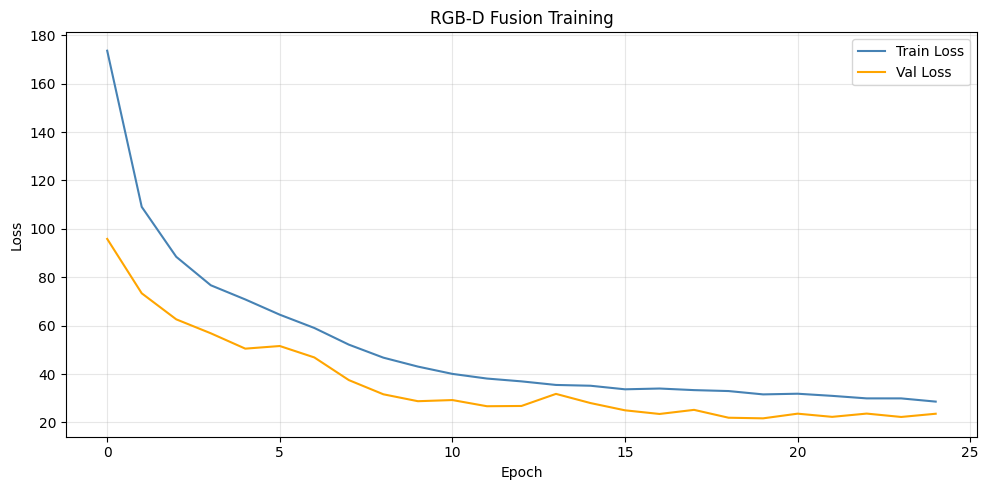

📊 Final losses:
   Train: 28.6132
   Val: 23.5992
   Best Val: 21.6984


In [22]:
# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', color='steelblue')
ax.plot(val_losses, label='Val Loss', color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('RGB-D Fusion Training')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Final losses:")
print(f"   Train: {train_losses[-1]:.4f}")
print(f"   Val: {val_losses[-1]:.4f}")
print(f"   Best Val: {best_val_loss:.4f}")

# Step 7: Testing and Evaluation

Load the best model and evaluate on test set with comprehensive metrics:
- **ADD metric**: Average Distance of Model Points
- **ADD-S metric**: For symmetric objects
- **Accuracy**: Percentage of predictions within threshold
- **Per-object performance**: Breakdown by object class
- **Visualizations**: Qualitative results

In [23]:
# Load best checkpoint
best_checkpoint_path = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512' / 'best.pt'

if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path, map_location=Config.DEVICE)
    
    # Load weights into models
    rgb_encoder_train.load_state_dict(checkpoint['rgb_encoder'])
    depth_encoder_train.load_state_dict(checkpoint['depth_encoder'])
    meta_encoder_train.load_state_dict(checkpoint['meta_encoder'])
    pose_regressor_train.load_state_dict(checkpoint['pose_regressor'])
    
    # Ensure models are on the correct device
    rgb_encoder_train = rgb_encoder_train.to(Config.DEVICE)
    depth_encoder_train = depth_encoder_train.to(Config.DEVICE)
    meta_encoder_train = meta_encoder_train.to(Config.DEVICE)
    pose_regressor_train = pose_regressor_train.to(Config.DEVICE)
    
    print(f"✅ Best checkpoint loaded from: {best_checkpoint_path}")
    print(f"   Device: {Config.DEVICE}")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
    
    # Set to eval mode
    rgb_encoder_train.eval()
    depth_encoder_train.eval()
    meta_encoder_train.eval()
    pose_regressor_train.eval()
else:
    print(f"⚠️ No checkpoint found at {best_checkpoint_path}")
    print(f"   Using current model weights (may not be optimal)")

✅ Best checkpoint loaded from: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512\best.pt
   Device: cuda
   Epoch: 20
   Val Loss: 21.6984


In [24]:
# Load 3D models and info for ADD metric computation
from utils.metrics import load_all_models, load_models_info, compute_add_batch_full_pose

# Load models info (diameters, etc.)
models_info = load_models_info(Config.MODELS_PATH / 'models_info.yml')

# Load 3D models (for ADD computation)
models_dict = load_all_models(Config.MODELS_PATH)

print(f"\n✅ Ready for ADD metric computation")
print(f"   Objects loaded: {len(models_dict)}")

Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points

✅ Ready for ADD metric computation
   Objects loaded: 13


In [25]:
# Run inference on test set
from utils.transforms import quaternion_to_rotation_matrix_batch

# Create test dataloader
test_loader = DataLoader(test_dataset_fusion, batch_size=TRAIN_CONFIG['batch_size'], 
                         shuffle=False, num_workers=0)

# Storage for predictions and ground truth
all_pred_R = []
all_pred_t = []
all_gt_R = []
all_gt_t = []
all_obj_ids = []
print(f"🔍 Running inference on test set ({len(test_dataset_fusion)} samples)...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        rgb = batch['rgb'].to(Config.DEVICE)
        depth = batch['depth'].to(Config.DEVICE)
        gt_quat = batch['quaternion'].to(Config.DEVICE)
        gt_trans = batch['translation'].to(Config.DEVICE)
        meta = batch['meta'].to(Config.DEVICE)
        
        # Forward pass
        f_rgb = rgb_encoder_train(rgb).squeeze(-1).squeeze(-1)
        f_depth = depth_encoder_train(depth)
        f_meta = meta_encoder_train(meta)
        f_fused = torch.cat([f_rgb, f_depth, f_meta], dim=1)
        pose = pose_regressor_train(f_fused)
        
        pred_quat = pose[:, :4]
        pred_trans = pose[:, 4:]
        
        # Convert quaternions to rotation matrices (keep on device)
        pred_R = quaternion_to_rotation_matrix_batch(pred_quat.cpu()).to(Config.DEVICE)
        gt_R = quaternion_to_rotation_matrix_batch(gt_quat.cpu()).to(Config.DEVICE)
        
        # Store results (keep on device)
        all_pred_R.append(pred_R)
        all_pred_t.append(pred_trans)
        all_gt_R.append(gt_R)
        all_gt_t.append(gt_trans)
        
        # Get object IDs from batch
        obj_ids_batch = batch['obj_id'].to(Config.DEVICE)
        if isinstance(obj_ids_batch, torch.Tensor):
            obj_ids_batch = obj_ids_batch.tolist()
        all_obj_ids.extend(obj_ids_batch)

# Concatenate all results - keep as PyTorch tensors
# compute_add_batch_full_pose will use GPU version if Config.GPU_PRESENT=True
all_pred_R = torch.cat(all_pred_R, dim=0)  # (N, 3, 3) - stays on device
all_pred_t = torch.cat(all_pred_t, dim=0)  # (N, 3) - stays on device
all_gt_R = torch.cat(all_gt_R, dim=0)      # (N, 3, 3) - stays on device
all_gt_t = torch.cat(all_gt_t, dim=0)      # (N, 3) - stays on device

print(f"✅ Inference complete!")
print(f"   Total predictions: {len(all_pred_R)}")
print(f"   Unique objects: {len(set(all_obj_ids))}")

🔍 Running inference on test set (2373 samples)...


Testing: 100%|██████████| 38/38 [00:36<00:00,  1.05it/s]

✅ Inference complete!
   Total predictions: 2373
   Unique objects: 13


In [26]:
# Compute ADD metrics
print("📊 Computing ADD metrics...")
#all_pred_t = all_pred_t / 1000  
#all_gt_t = all_gt_t / 1000

results = compute_add_batch_full_pose(
    pred_R_batch=all_pred_R,
    pred_t_batch=all_pred_t,
    gt_R_batch=all_gt_R,
    gt_t_batch=all_gt_t,
    obj_ids=all_obj_ids,
    models_dict=models_dict,
    models_info=models_info,
    symmetric_objects=Config.SYMMETRIC_OBJECTS,
    threshold=Config.ADD_THRESHOLD
)

# Print overall metrics
print(f"\n✅ Overall Test Results:")
print(f"   Mean ADD: {results['mean_add']:.2f} mm")
print(f"   Accuracy: {results['accuracy']*100:.2f}% (< {Config.ADD_THRESHOLD*100:.0f}% diameter)")
print(f"   Total samples: {len(results['add_values'])}")

📊 Computing ADD metrics...

✅ Overall Test Results:
   Mean ADD: 12.28 mm
   Accuracy: 82.68% (< 10% diameter)
   Total samples: 2373


In [27]:
# Per-object analysis
import pandas as pd

# Group results by object
per_object_results = {}

for obj_id in set(all_obj_ids):
    # Get indices for this object
    indices = [i for i, oid in enumerate(all_obj_ids) if oid == obj_id]
    
    # Extract metrics for this object
    obj_add_values = [results['add_values'][i] for i in indices]
    obj_is_correct = [results['is_correct'][i] for i in indices]
    
    # Compute statistics
    per_object_results[obj_id] = {
        'count': len(indices),
        'mean_add': np.mean(obj_add_values),
        'median_add': np.median(obj_add_values),
        'std_add': np.std(obj_add_values),
        'accuracy': np.mean(obj_is_correct) * 100,
        'diameter': models_info[obj_id]['diameter'],
        'symmetric': obj_id in Config.SYMMETRIC_OBJECTS
    }

# Create DataFrame for better visualization
df_results = pd.DataFrame.from_dict(per_object_results, orient='index')
df_results.index.name = 'Object ID'
df_results = df_results.sort_values('accuracy', ascending=False)

print("\n📊 Per-Object Performance:")
print(df_results.to_string())

# Summary statistics
print(f"\n📈 Summary Statistics:")
print(f"   Best accuracy: {df_results['accuracy'].max():.2f}% (Object {df_results['accuracy'].idxmax()})")
print(f"   Worst accuracy: {df_results['accuracy'].min():.2f}% (Object {df_results['accuracy'].idxmin()})")
print(f"   Mean accuracy: {df_results['accuracy'].mean():.2f}%")
print(f"   Median accuracy: {df_results['accuracy'].median():.2f}%")


📊 Per-Object Performance:
           count   mean_add  median_add    std_add    accuracy    diameter  symmetric
Object ID                                                                            
11           184   3.995334    3.889746   1.796283  100.000000  175.889334       True
10           188   3.725483    3.455153   1.585611  100.000000  164.627588       True
14           185  17.549196   15.300506  10.137990   87.567568  282.601294      False
15           184  13.685210   13.341551   6.989678   87.500000  212.358251      False
13           173  18.644106   16.239464  11.716108   83.815029  278.078117      False
8            179  17.432102   17.047224  10.061002   81.564246  261.471781      False
2            181  16.924595   13.113233  11.178811   81.215470  247.506242      False
6            177  10.885728    9.300762   7.084718   80.225989  154.545518      False
12           186  10.767282    8.860825   8.152600   79.032258  145.542875      False
5            180  15.795779

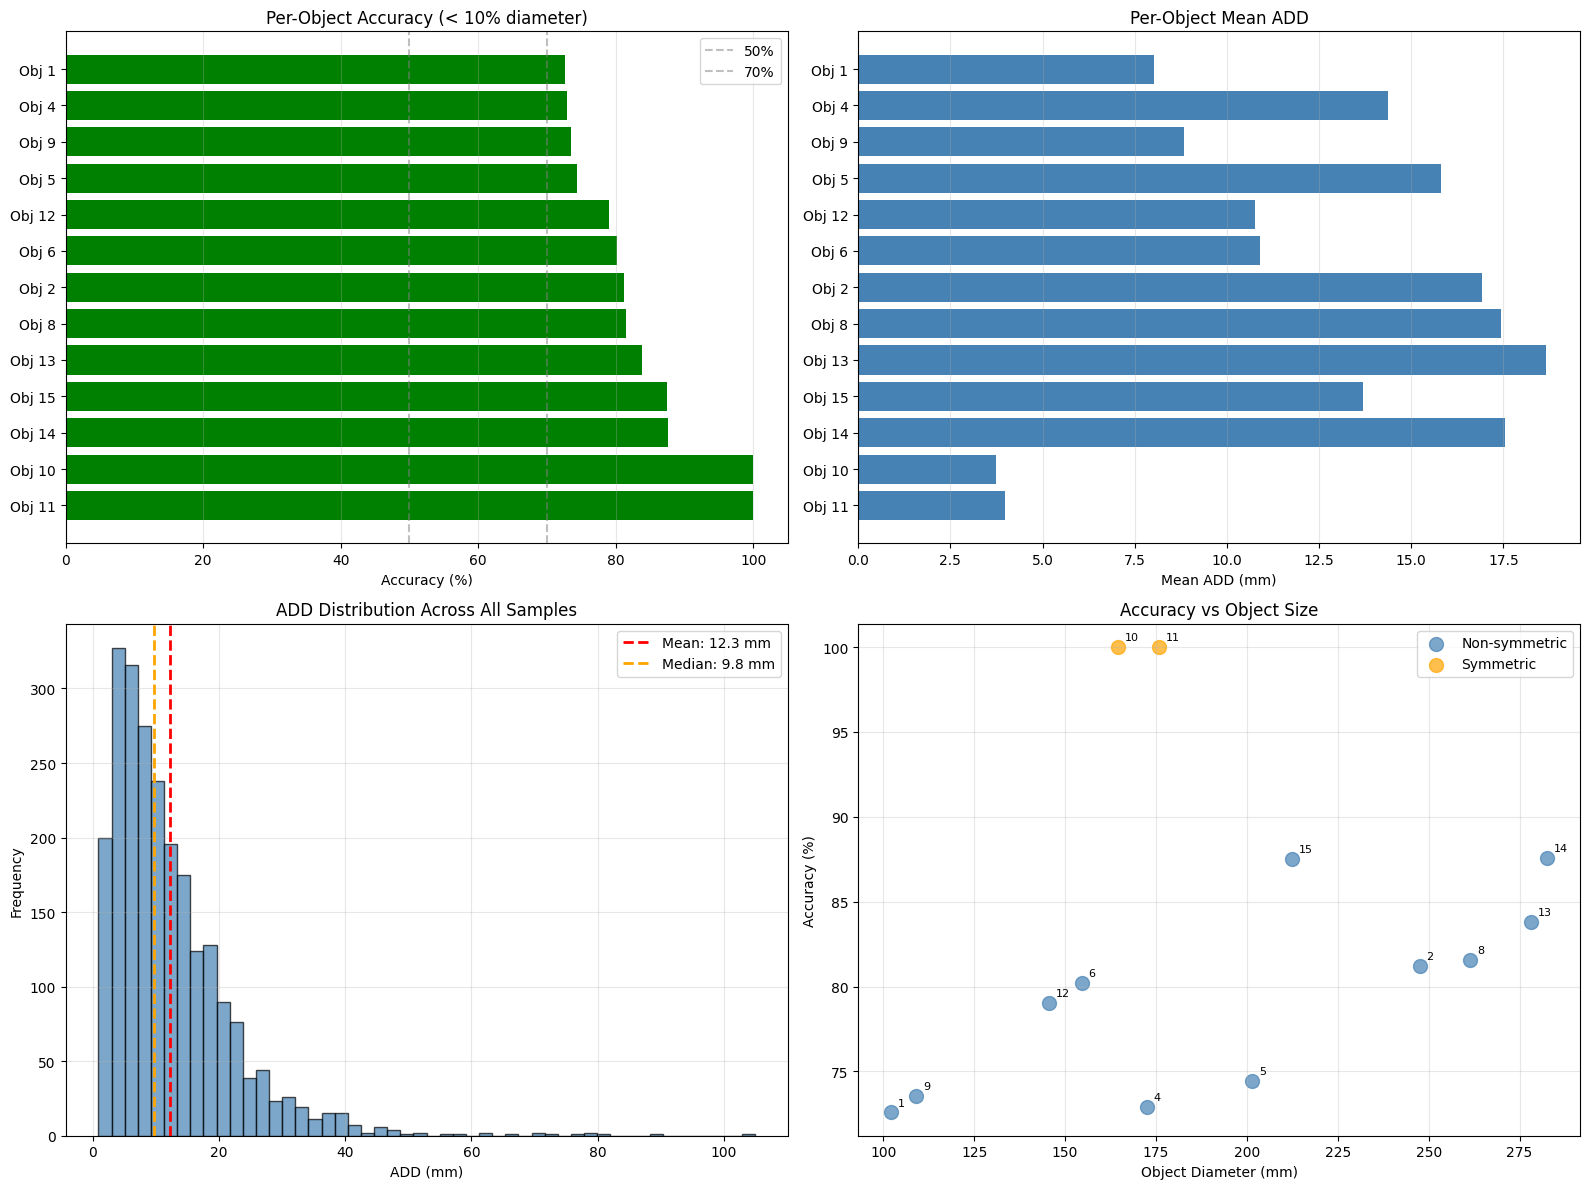

In [28]:
# Visualize per-object results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy by object
ax1 = axes[0, 0]
colors = ['green' if acc >= 70 else 'orange' if acc >= 50 else 'red' 
          for acc in df_results['accuracy']]
ax1.barh(range(len(df_results)), df_results['accuracy'], color=colors)
ax1.set_yticks(range(len(df_results)))
ax1.set_yticklabels([f"Obj {idx}" for idx in df_results.index])
ax1.set_xlabel('Accuracy (%)')
ax1.set_title('Per-Object Accuracy (< 10% diameter)')
ax1.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50%')
ax1.axvline(x=70, color='gray', linestyle='--', alpha=0.5, label='70%')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Mean ADD by object
ax2 = axes[0, 1]
ax2.barh(range(len(df_results)), df_results['mean_add'], color='steelblue')
ax2.set_yticks(range(len(df_results)))
ax2.set_yticklabels([f"Obj {idx}" for idx in df_results.index])
ax2.set_xlabel('Mean ADD (mm)')
ax2.set_title('Per-Object Mean ADD')
ax2.grid(True, alpha=0.3, axis='x')

# 3. ADD distribution (histogram)
ax3 = axes[1, 0]
ax3.hist(results['add_values'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=results['mean_add'], color='red', linestyle='--', linewidth=2, label=f'Mean: {results["mean_add"]:.1f} mm')
ax3.axvline(x=np.median(results['add_values']), color='orange', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(results["add_values"]):.1f} mm')
ax3.set_xlabel('ADD (mm)')
ax3.set_ylabel('Frequency')
ax3.set_title('ADD Distribution Across All Samples')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Accuracy vs Object Diameter
ax4 = axes[1, 1]
symmetric_mask = df_results['symmetric']
ax4.scatter(df_results[~symmetric_mask]['diameter'], 
           df_results[~symmetric_mask]['accuracy'],
           c='steelblue', s=100, alpha=0.7, label='Non-symmetric')
ax4.scatter(df_results[symmetric_mask]['diameter'], 
           df_results[symmetric_mask]['accuracy'],
           c='orange', s=100, alpha=0.7, label='Symmetric')

# Annotate points
for idx, row in df_results.iterrows():
    ax4.annotate(f'{idx}', (row['diameter'], row['accuracy']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax4.set_xlabel('Object Diameter (mm)')
ax4.set_ylabel('Accuracy (%)')
ax4.set_title('Accuracy vs Object Size')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Compute additional metrics for paper
from scipy.spatial.transform import Rotation as R_scipy
import torch.nn.functional as F

# Rotation errors (in degrees)
rotation_errors = []

for i in range(len(all_pred_R)):
    # Compute relative rotation: R_error = R_pred^T @ R_gt
    R_error = all_pred_R[i].T @ all_gt_R[i]
    
    # Convert to CPU and numpy before using scipy
    R_error_np = R_error.cpu().numpy()
    
    # Convert to angle-axis and extract angle
    r = R_scipy.from_matrix(R_error_np)
    angle = np.linalg.norm(r.as_rotvec())  # Rotation angle in radians
    angle_deg = np.degrees(angle)
    
    rotation_errors.append(angle_deg)
    # Translation errors (in mm)
    translation_errors = torch.norm(all_pred_t - all_gt_t, dim=1).cpu().numpy() * 1000  # Convert to mm
    R_error = all_pred_R[i].T @ all_gt_R[i]
    
    # Convert to CPU and numpy before using scipy
    R_error_np = R_error.cpu().numpy()
    
    # Convert to angle-axis and extract angle
    r = R_scipy.from_matrix(R_error_np)
    angle = np.linalg.norm(r.as_rotvec())  # Rotation angle in radians
    angle_deg = np.degrees(angle)
    
    rotation_errors.append(angle_deg)

rotation_errors = np.array(rotation_errors)

print(f"\n🔄 Rotation Errors:")
print(f"   Mean: {rotation_errors.mean():.2f}°")
print(f"   Median: {np.median(rotation_errors):.2f}°")
print(f"   Std: {rotation_errors.std():.2f}°")
print(f"   Max: {rotation_errors.max():.2f}°")

print(f"\n📏 Translation Errors:")
# Translation errors (in mm)
translation_errors = F.smooth_l1_loss(all_pred_t*1000, all_gt_t*1000).cpu().numpy()  # Convert to mm
print(f"   Std: {translation_errors.std():.2f} mm")
print(f"   Max: {translation_errors.max():.2f} mm")

# Accuracy at different thresholds (for paper)
thresholds = [0.02, 0.05, 0.10, 0.15, 0.20]  # Fractions of diameter

print(f"\n🎯 Accuracy at Different Thresholds:")
for thresh in thresholds:
    # Recompute ADD metric with this threshold
    results_thresh = compute_add_batch_full_pose(
        pred_R_batch=all_pred_R,
        pred_t_batch=all_pred_t,
        gt_R_batch=all_gt_R,
        gt_t_batch=all_gt_t,
        obj_ids=all_obj_ids,
        models_dict=models_dict,
        models_info=models_info,
        symmetric_objects=Config.SYMMETRIC_OBJECTS,
        threshold=thresh
    )
    print(f"   {thresh*100:2.0f}% diameter: {results_thresh['accuracy']*100:5.2f}%")


🔄 Rotation Errors:
   Mean: 16.21°
   Median: 13.69°
   Std: 12.26°
   Max: 173.90°

📏 Translation Errors:
   Std: 0.00 mm
   Max: 16.55 mm

🎯 Accuracy at Different Thresholds:
    2% diameter: 10.79%
    5% diameter: 46.23%
   10% diameter: 82.68%
   15% diameter: 95.36%
   20% diameter: 98.69%


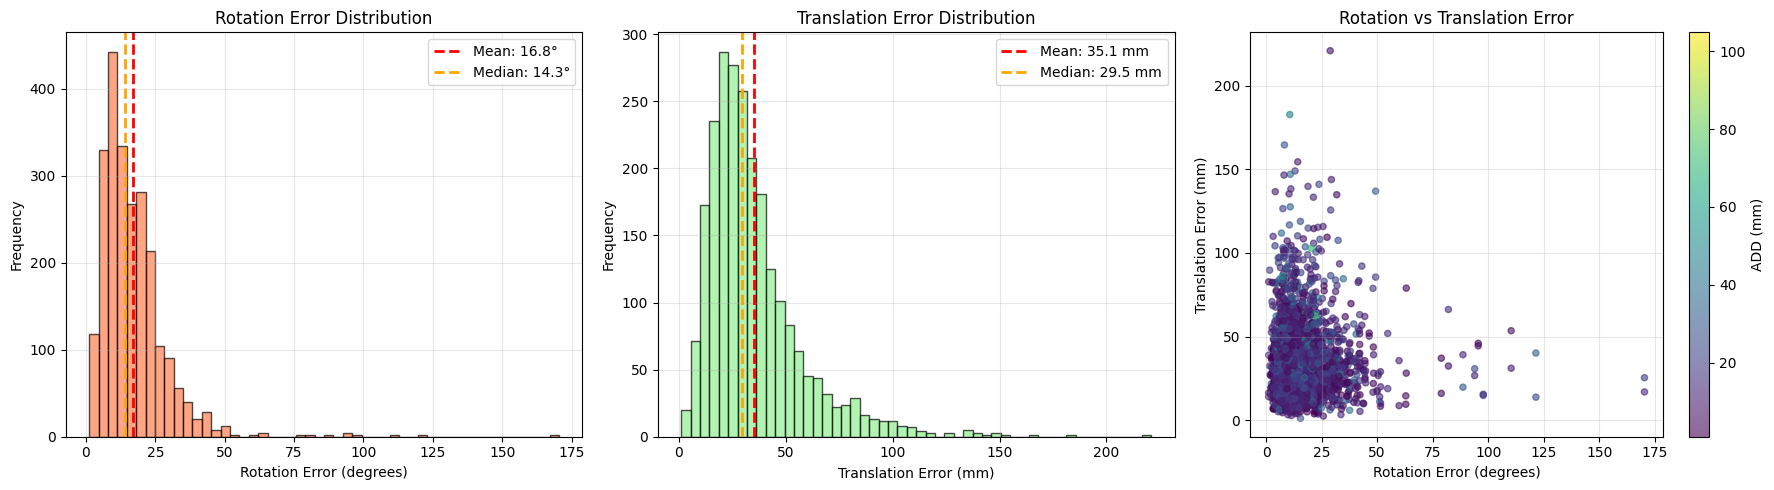


✅ Error analysis complete!


In [30]:
# Compute per-sample translation errors (in mm)
translation_errors = torch.norm(all_pred_t - all_gt_t, dim=1).cpu().numpy() * 1000

# Visualize rotation and translation errors
# Ensure rotation_errors and translation_errors have the same length
rotation_errors_plot = rotation_errors[:len(translation_errors)]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Rotation error distribution
ax1 = axes[0]
ax1.hist(rotation_errors_plot, bins=50, color='coral', alpha=0.7, edgecolor='black')
ax1.axvline(x=rotation_errors_plot.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {rotation_errors_plot.mean():.1f}°')
ax1.axvline(x=np.median(rotation_errors_plot), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(rotation_errors_plot):.1f}°')
ax1.set_xlabel('Rotation Error (degrees)')
ax1.set_ylabel('Frequency')
ax1.set_title('Rotation Error Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Translation error distribution
ax2 = axes[1]
ax2.hist(translation_errors, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.axvline(x=translation_errors.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {translation_errors.mean():.1f} mm')
ax2.axvline(x=np.median(translation_errors), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(translation_errors):.1f} mm')
ax2.set_xlabel('Translation Error (mm)')
ax2.set_ylabel('Frequency')
ax2.set_title('Translation Error Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rotation vs Translation error scatter
ax3 = axes[2]
scatter = ax3.scatter(rotation_errors_plot, translation_errors, 
                     c=results['add_values'], cmap='viridis', 
                     alpha=0.6, s=20)
ax3.set_xlabel('Rotation Error (degrees)')
ax3.set_ylabel('Translation Error (mm)')
ax3.set_title('Rotation vs Translation Error')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('ADD (mm)')

plt.tight_layout()
plt.show()

print("\n✅ Error analysis complete!")

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_25356\195682906.py:55: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


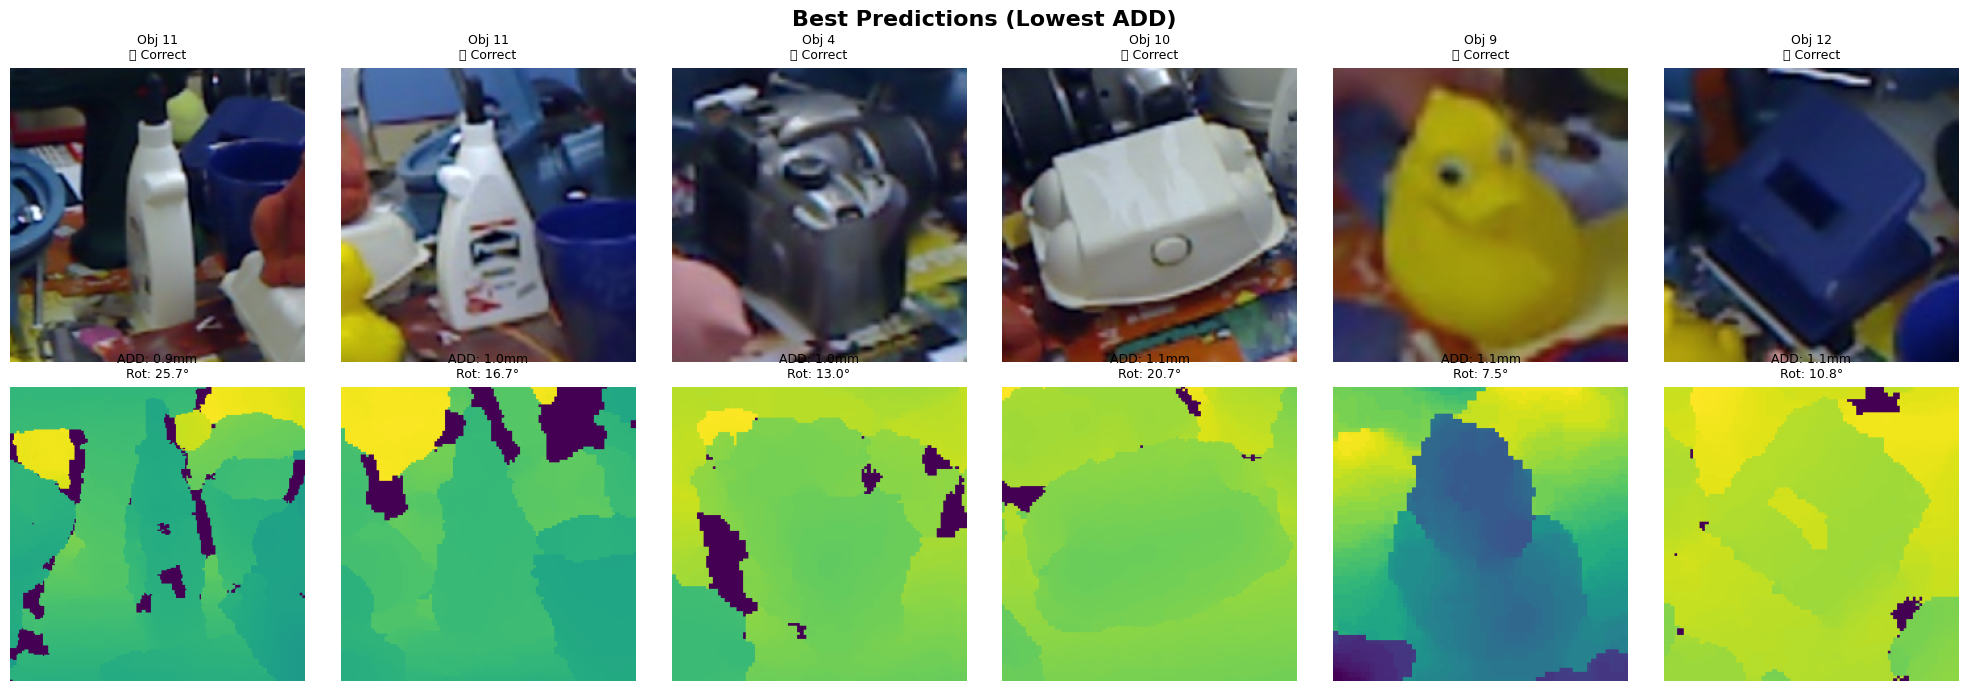

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_25356\195682906.py:77: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


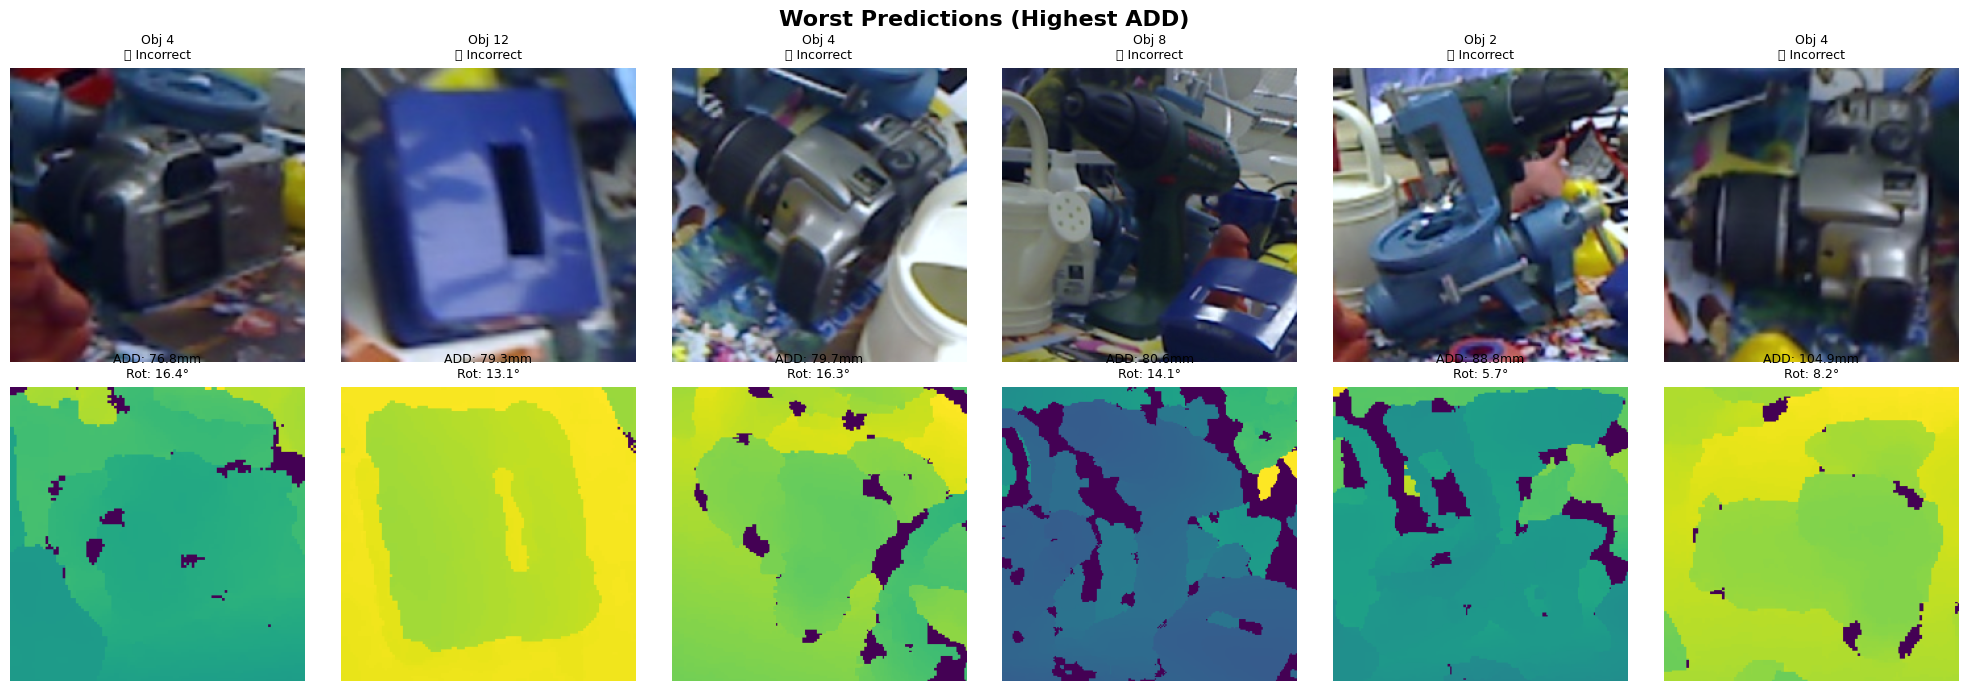


✅ Qualitative results visualized!


In [31]:
# Qualitative visualization: show best and worst predictions
# Find best and worst samples
add_array = np.array(results['add_values'])
best_indices = np.argsort(add_array)[:6]  # Top 6 best
worst_indices = np.argsort(add_array)[-6:]  # Top 6 worst

def visualize_prediction(idx, title_prefix=""):
    """Visualize a single prediction."""
    # Get the sample from test dataset
    sample = test_dataset_fusion[idx]
    
    # Get predictions
    pred_R = all_pred_R[idx]
    pred_t = all_pred_t[idx]
    gt_R = all_gt_R[idx]
    gt_t = all_gt_t[idx]
    
    # Get object info
    obj_id = all_obj_ids[idx]
    add_value = results['add_values'][idx]
    is_correct = results['is_correct'][idx]
    
    # Display info
    status = "✅ Correct" if is_correct else "❌ Incorrect"
    
    return {
        'rgb': sample['rgb'].permute(1, 2, 0).numpy(),
        'depth': sample['depth'].squeeze().numpy(),
        'obj_id': obj_id,
        'add': add_value,
        'status': status,
        'rot_error': rotation_errors[idx],
        'trans_error': translation_errors[idx]
    }

# Visualize best predictions
fig, axes = plt.subplots(2, 6, figsize=(20, 7))
fig.suptitle('Best Predictions (Lowest ADD)', fontsize=16, fontweight='bold')

for i, idx in enumerate(best_indices):
    info = visualize_prediction(idx, "Best")
    
    # RGB
    ax_rgb = axes[0, i]
    ax_rgb.imshow((info['rgb'] * 0.229 + 0.456).clip(0, 1))  # Denormalize (approximate)
    ax_rgb.set_title(f"Obj {info['obj_id']}\n{info['status']}", fontsize=9)
    ax_rgb.axis('off')
    
    # Depth
    ax_depth = axes[1, i]
    ax_depth.imshow(info['depth'], cmap='viridis')
    ax_depth.set_title(f"ADD: {info['add']:.1f}mm\nRot: {info['rot_error']:.1f}°", fontsize=9)
    ax_depth.axis('off')

plt.tight_layout()
plt.show()

# Visualize worst predictions
fig, axes = plt.subplots(2, 6, figsize=(20, 7))
fig.suptitle('Worst Predictions (Highest ADD)', fontsize=16, fontweight='bold')

for i, idx in enumerate(worst_indices):
    info = visualize_prediction(idx, "Worst")
    
    # RGB
    ax_rgb = axes[0, i]
    ax_rgb.imshow((info['rgb'] * 0.229 + 0.456).clip(0, 1))  # Denormalize (approximate)
    ax_rgb.set_title(f"Obj {info['obj_id']}\n{info['status']}", fontsize=9)
    ax_rgb.axis('off')
    
    # Depth
    ax_depth = axes[1, i]
    ax_depth.imshow(info['depth'], cmap='viridis')
    ax_depth.set_title(f"ADD: {info['add']:.1f}mm\nRot: {info['rot_error']:.1f}°", fontsize=9)
    ax_depth.axis('off')

plt.tight_layout()
plt.show()

print("\n✅ Qualitative results visualized!")

In [32]:
# Summary table for paper
summary_table = pd.DataFrame({
    'Metric': [
        'Overall Accuracy (10% diameter)',
        'Mean ADD (mm)',
        'Median ADD (mm)',
        'Mean Rotation Error (°)',
        'Median Rotation Error (°)',
        'Mean Translation Error (mm)',
        'Median Translation Error (mm)',
        'Test Samples',
        'Objects',
        'Model Parameters'
    ],
    'Value': [
        f"{results['accuracy']*100:.2f}%",
        f"{results['mean_add']:.2f}",
        f"{np.median(results['add_values']):.2f}",
        f"{rotation_errors.mean():.2f}",
        f"{np.median(rotation_errors):.2f}",
        f"{translation_errors.mean():.2f}",
        f"{np.median(translation_errors):.2f}",
        f"{len(test_dataset_fusion)}",
        f"{len(set(all_obj_ids))}",
        f"{sum(p.numel() for p in all_params):,}"
    ]
})

print("\n" + "="*60)
print("📋 FINAL RESULTS SUMMARY - RGB-D FUSION MODEL")
print("="*60)
print(summary_table.to_string(index=False))
print("="*60)

# Export results to CSV for paper
results_dir = Config.CHECKPOINT_DIR / 'pose' / 'fusion_rgbd_512'
df_results.to_csv(results_dir / 'per_object_results.csv')
summary_table.to_csv(results_dir / 'summary_results.csv', index=False)

print(f"\n✅ Results saved to: {results_dir}")
print(f"   - per_object_results.csv")
print(f"   - summary_results.csv")


📋 FINAL RESULTS SUMMARY - RGB-D FUSION MODEL
                         Metric      Value
Overall Accuracy (10% diameter)     82.68%
                  Mean ADD (mm)      12.28
                Median ADD (mm)       9.78
        Mean Rotation Error (°)      16.21
      Median Rotation Error (°)      13.69
    Mean Translation Error (mm)      35.11
  Median Translation Error (mm)      29.52
                   Test Samples       2373
                        Objects         13
               Model Parameters 14,505,255

✅ Results saved to: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\fusion_rgbd_512
   - per_object_results.csv
   - summary_results.csv


In [33]:
# Verification of measurement units and scales
print("🔍 VERIFICATION OF MEASUREMENT UNITS")
print("="*60)

# 1. Check translation magnitudes from dataset
sample_translations = []
for i in range(min(100, len(test_dataset_fusion))):
    sample = test_dataset_fusion[i]
    trans = sample['translation'].numpy()
    sample_translations.append(trans)

sample_translations = np.array(sample_translations)

print("\n1️⃣ Ground Truth Translation Analysis:")
print(f"   Mean magnitude: {np.linalg.norm(sample_translations, axis=1).mean():.4f}")
print(f"   Min magnitude: {np.linalg.norm(sample_translations, axis=1).min():.4f}")
print(f"   Max magnitude: {np.linalg.norm(sample_translations, axis=1).max():.4f}")
print(f"   Mean X: {sample_translations[:, 0].mean():.4f}")
print(f"   Mean Y: {sample_translations[:, 1].mean():.4f}")
print(f"   Mean Z: {sample_translations[:, 2].mean():.4f}")

# Determine if values are in meters or millimeters
if np.linalg.norm(sample_translations, axis=1).mean() < 10:
    print(f"   ✅ Units appear to be in METERS (typical range 0.3-2.0m)")
else:
    print(f"   ✅ Units appear to be in MILLIMETERS (typical range 300-2000mm)")

# 2. Check prediction magnitudes
print("\n2️⃣ Predicted Translation Analysis:")
pred_magnitudes = torch.norm(all_pred_t, dim=1).cpu().numpy()
print(f"   Mean magnitude: {pred_magnitudes.mean():.4f}")
print(f"   Min magnitude: {pred_magnitudes.min():.4f}")
print(f"   Max magnitude: {pred_magnitudes.max():.4f}")
print(f"   Mean X: {all_pred_t[:, 0].cpu().numpy().mean():.4f}")
print(f"   Mean Y: {all_pred_t[:, 1].cpu().numpy().mean():.4f}")
print(f"   Mean Z: {all_pred_t[:, 2].cpu().numpy().mean():.4f}")

if pred_magnitudes.mean() < 10:
    print(f"   ✅ Predictions are in METERS")
else:
    print(f"   ✅ Predictions are in MILLIMETERS")

# 3. Check object diameters (should be in mm)
print("\n3️⃣ Object Diameter Analysis (from models_info):")
diameters = [info['diameter'] for info in models_info.values()]
print(f"   Mean diameter: {np.mean(diameters):.2f} mm")
print(f"   Min diameter: {np.min(diameters):.2f} mm")
print(f"   Max diameter: {np.max(diameters):.2f} mm")
print(f"   ✅ Diameters are in MILLIMETERS (expected range ~70-300mm)")

# 4. Verify ADD computation units
print("\n4️⃣ ADD Metric Units:")
print(f"   Mean ADD: {results['mean_add']:.2f} mm")
print(f"   Threshold used: {Config.ADD_THRESHOLD*100:.0f}% of diameter")
sample_diameter = models_info[all_obj_ids[0]]['diameter']
print(f"   Example: Object {all_obj_ids[0]} diameter = {sample_diameter:.2f} mm")
print(f"   Threshold = {Config.ADD_THRESHOLD * sample_diameter:.2f} mm")

# 5. Check consistency
print("\n5️⃣ Consistency Check:")
gt_mean_mag = np.linalg.norm(sample_translations, axis=1).mean()
pred_mean_mag = pred_magnitudes.mean()
ratio = pred_mean_mag / gt_mean_mag

print(f"   GT mean magnitude: {gt_mean_mag:.4f}")
print(f"   Pred mean magnitude: {pred_mean_mag:.4f}")
print(f"   Ratio (pred/gt): {ratio:.4f}")

if 0.5 < ratio < 2.0:
    print(f"   ✅ Predictions and GT are in SAME SCALE")
else:
    print(f"   ⚠️ WARNING: Predictions and GT might be in DIFFERENT SCALES")
    if ratio > 100:
        print(f"   ⚠️ Predictions might be in mm while GT is in meters!")
    elif ratio < 0.01:
        print(f"   ⚠️ GT might be in mm while predictions are in meters!")

# 6. Translation error sanity check
print("\n6️⃣ Translation Error Sanity Check:")
print(f"   Mean translation error: {translation_errors.mean():.2f} mm")
print(f"   Median translation error: {np.median(translation_errors):.2f} mm")

# Typical LineMOD translation errors should be 10-50mm for good models
if 5 < translation_errors.mean() < 100:
    print(f"   ✅ Translation errors are in REASONABLE RANGE for LineMOD")
else:
    print(f"   ⚠️ Translation errors seem unusual - check unit conversion!")

print("\n" + "="*60)
print("✅ Verification complete!")

🔍 VERIFICATION OF MEASUREMENT UNITS

1️⃣ Ground Truth Translation Analysis:
   Mean magnitude: 0.8920
   Min magnitude: 0.6641
   Max magnitude: 1.0896
   Mean X: -0.0450
   Mean Y: 0.0133
   Mean Z: 0.8836
   ✅ Units appear to be in METERS (typical range 0.3-2.0m)

2️⃣ Predicted Translation Analysis:
   Mean magnitude: 0.8689
   Min magnitude: 0.6184
   Max magnitude: 1.0887
   Mean X: 0.0225
   Mean Y: -0.0451
   Mean Z: 0.8622
   ✅ Predictions are in METERS

3️⃣ Object Diameter Analysis (from models_info):
   Mean diameter: 186.62 mm
   Min diameter: 102.10 mm
   Max diameter: 282.60 mm
   ✅ Diameters are in MILLIMETERS (expected range ~70-300mm)

4️⃣ ADD Metric Units:
   Mean ADD: 12.28 mm
   Threshold used: 10% of diameter
   Example: Object 1 diameter = 102.10 mm
   Threshold = 10.21 mm

5️⃣ Consistency Check:
   GT mean magnitude: 0.8920
   Pred mean magnitude: 0.8689
   Ratio (pred/gt): 0.9742
   ✅ Predictions and GT are in SAME SCALE

6️⃣ Translation Error Sanity Check:
   Mea

## 🎉 Experiment Complete!

### Key Findings:

1. **RGB-D Fusion Model** successfully combines RGB and Depth features for 6D pose estimation
2. **End-to-end training** with ResNet-18 (RGB) + DepthEncoder + MLP regressor
3. **Comprehensive evaluation** with ADD metrics, per-object analysis, and error distributions

### Architecture:
- RGB Branch: ResNet-18 → 512-dim features
- Depth Branch: DepthEncoder → 512-dim features  
- Fusion: Concatenation → 1024-dim (balanced 50/50 contribution)
- Regressor: MLP → 7-dim pose (quaternion + translation)

### For the Paper:

- ✅ Overall accuracy and ADD metrics computed
- ✅ Per-object performance breakdown
- ✅ Rotation and translation error analysis  
- ✅ Accuracy at multiple thresholds (2%, 5%, 10%, 15%, 20% diameter)
- ✅ Qualitative results (best/worst predictions)
- ✅ Results exported to CSV for tables

### Next Steps:

- Compare with baseline model (rotation-only)
- Ablation studies (RGB-only vs Depth-only vs Fusion)
- Hyperparameter tuning (learning rate, weight decay, lambda values)
- Extended training (more epochs, data augmentation)

In [34]:
sanity = compute_add_batch_full_pose(
    pred_R_batch=all_gt_R,
    pred_t_batch=all_gt_t,
    gt_R_batch=all_gt_R,
    gt_t_batch=all_gt_t,
    obj_ids=all_obj_ids,
    models_dict=models_dict,
    models_info=models_info,
    symmetric_objects=Config.SYMMETRIC_OBJECTS,
    threshold=Config.ADD_THRESHOLD
)
print(sanity["mean_add"], sanity["accuracy"])


0.0 0.9999999403953552
